In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics.pairwise import cosine_similarity

file_path = '/kaggle/input/original-hiring-dataset/Hiring_dataset.csv'
df = pd.read_csv(file_path)

num_features = df.select_dtypes(exclude=['object']).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())
                        ])

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_features),
                                               ('cat', cat_pipeline, cat_features)])

X = preprocessor.fit_transform(df)

X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor.shape

torch.Size([1500, 17])

In [2]:
#Autoencoder and decoder model for word emedding
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        embeddings = self.encoder(x)
        reconstructed = self.decoder(embeddings)
        return reconstructed, embeddings

In [3]:
# Initialize model and Optimizers
input_dim = X_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 80
batch_size = 32

loss_history = []
test_loss_history = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for i in range(0, len(X_tensor), batch_size):
        x_batch = X_tensor[i:i + batch_size]

        optimizer.zero_grad()
        reconstructed, _ = model(x_batch)
        
        loss = criterion(reconstructed, x_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / (len(X_tensor) / batch_size)
    loss_history.append(avg_loss)
    

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 10/80, Loss: 0.0470
Epoch 20/80, Loss: 0.0205
Epoch 30/80, Loss: 0.0152
Epoch 40/80, Loss: 0.0119
Epoch 50/80, Loss: 0.0098
Epoch 60/80, Loss: 0.0090
Epoch 70/80, Loss: 0.0082
Epoch 80/80, Loss: 0.0081


In [4]:
#Extract embeddings and # Convert embeddings to numpy array
with torch.no_grad():
    _, embeddings = model(X_tensor)

embeddings_np = embeddings.numpy()
embeddings_np.shape

(1500, 32)

In [5]:
type(embeddings_np)

numpy.ndarray

In [6]:
embeddings.shape

torch.Size([1500, 32])

In [7]:
#Recommend top N candidates based on cosine similarity.
#cosine similarity
# Sort by similarity

def recommend_candidates(query_index, embeddings, top_n=5):
    similarities = cosine_similarity([embeddings[query_index]], embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][:top_n + 1]  # Include self in top candidates
    top_indices = [idx for idx in top_indices if idx != query_index][:top_n]  # Exclude self-match

    # Display results
    print(f"\nTop {top_n} Candidates for Candidate {query_index}:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. Candidate {idx} - Similarity: {similarities[idx]:.4f}")

recommend_candidates(0, embeddings_np, top_n=5)


Top 5 Candidates for Candidate 0:
1. Candidate 198 - Similarity: 0.9577
2. Candidate 836 - Similarity: 0.9102
3. Candidate 1323 - Similarity: 0.9018
4. Candidate 171 - Similarity: 0.8743
5. Candidate 564 - Similarity: 0.8588


In [8]:
def match_candidate(sample, preprocessor, model, embeddings_np, top_n=5):
    """
    Match a sample candidate with the most similar candidates from the dataset.
    Display the full candidate details along with their similarity scores.
    """
    # Preprocess the sample using the same preprocessor
    sample_df = pd.DataFrame([sample], columns=df.columns)
    sample_processed = preprocessor.transform(sample_df)
    
    # Convert to PyTorch tensor
    sample_tensor = torch.tensor(sample_processed, dtype=torch.float32)

    # Extract the embedding for the new candidate
    model.eval()
    with torch.no_grad():
        _, sample_embedding = model(sample_tensor)
    
    # Compute cosine similarity with existing embeddings
    sample_embedding_np = sample_embedding.numpy()
    similarities = cosine_similarity(sample_embedding_np, embeddings_np)[0]

    # Sort and display top N matches
    top_indices = np.argsort(similarities)[::-1][:top_n]

    print(f"\n Top {top_n} Similar Candidates for the Sample:")
    
    for i, idx in enumerate(top_indices):
        similarity_score = similarities[idx]
        candidate_details = df.iloc[idx].to_dict()
        
        print(f"\n {i+1}. Candidate {idx} - Similarity: {similarity_score:.4f}")
        
        # Print the full candidate details
        for key, value in candidate_details.items():
            print(f"    {key}: {value}")

In [9]:
# Sample input
sample_candidate = {
    'Age': 22,
    'Gender': 'Male',
    'EducationLevel': 'Phd',
    'ExperienceYears': 4,
    'PreviousCompanies': 5,
    'DistanceFromCompany': 16,
    'InterviewScore': 68,
    'SkillScore': 85,
    'PersonalityScore': 43,
    'RecruitmentStrategy': 'Moderate',
    'HiringDecision':0
}

# Match the sample candidate with the dataset
match_candidate(sample_candidate, preprocessor, model, embeddings_np, top_n=5)


 Top 5 Similar Candidates for the Sample:

 1. Candidate 517 - Similarity: 0.9024
    Age: 22
    Gender: Male
    EducationLevel: Bachelor's (Type 2)
    ExperienceYears: 4
    PreviousCompanies: 5
    DistanceFromCompany: 16
    InterviewScore: 68
    SkillScore: 84
    PersonalityScore: 43
    RecruitmentStrategy: Moderate
    HiringDecision: 0

 2. Candidate 745 - Similarity: 0.8054
    Age: 22
    Gender: Male
    EducationLevel: Master's
    ExperienceYears: 5
    PreviousCompanies: 4
    DistanceFromCompany: 10
    InterviewScore: 61
    SkillScore: 89
    PersonalityScore: 61
    RecruitmentStrategy: Moderate
    HiringDecision: 0

 3. Candidate 1358 - Similarity: 0.7581
    Age: 24
    Gender: Male
    EducationLevel: Bachelor's (Type 2)
    ExperienceYears: 3
    PreviousCompanies: 5
    DistanceFromCompany: 2
    InterviewScore: 11
    SkillScore: 99
    PersonalityScore: 40
    RecruitmentStrategy: Moderate
    HiringDecision: 0

 4. Candidate 206 - Similarity: 0.7453
    

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


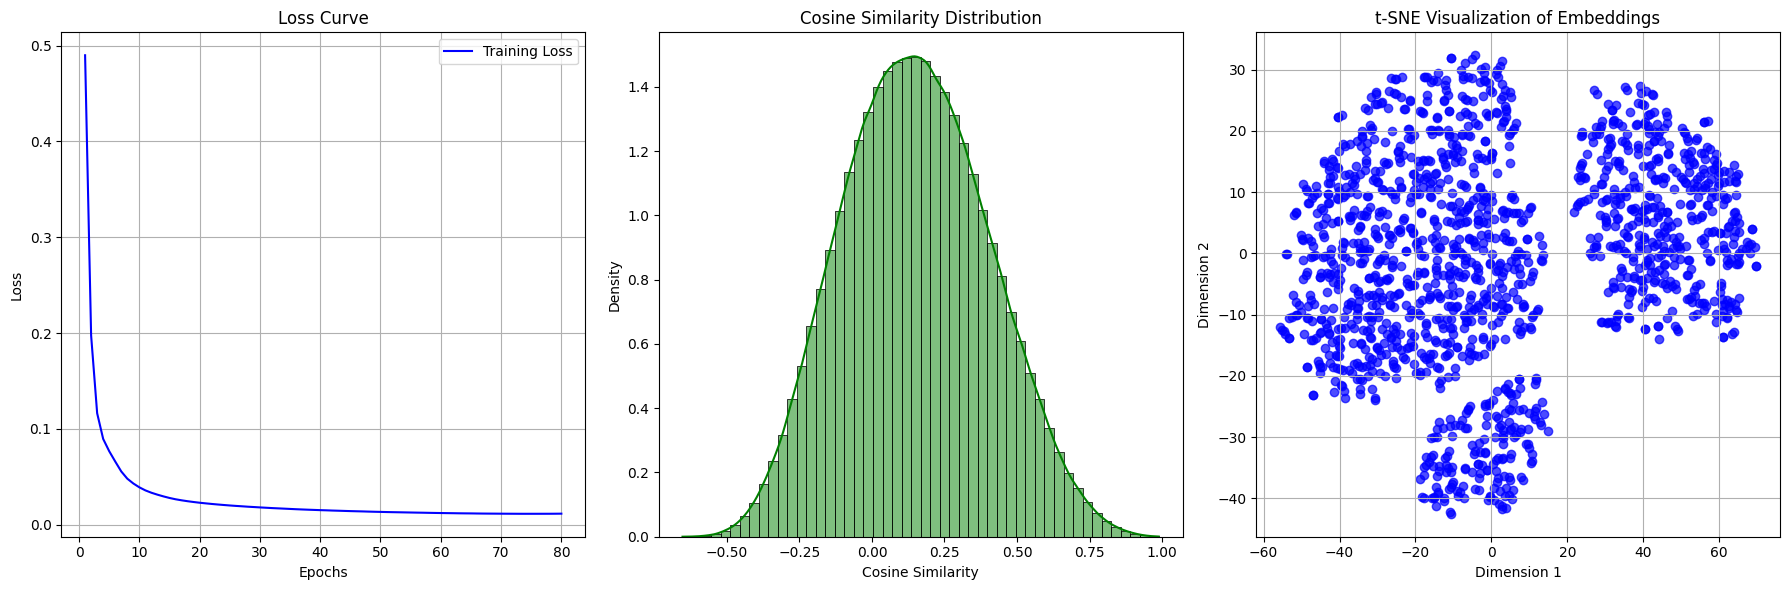

In [10]:
from sklearn.manifold import TSNE
# 1. Plotting the Loss Curve  # 2. Cosine Similarity Distribution  # 3. t-SNE Visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust the size as needed
axs[0].plot(range(1, epochs + 1), loss_history, label='Training Loss', color='blue')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss Curve')
axs[0].grid(True)
axs[0].legend()

similarities = cosine_similarity(embeddings_np)
sim_scores = similarities[np.triu_indices_from(similarities, k=1)]
sns.histplot(sim_scores, bins=50, kde=True, color='green', stat='density', ax=axs[1])
axs[1].set_title('Cosine Similarity Distribution')
axs[1].set_xlabel('Cosine Similarity')
axs[1].set_ylabel('Density')

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)
axs[2].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.7)
axs[2].set_title('t-SNE Visualization of Embeddings')
axs[2].set_xlabel('Dimension 1')
axs[2].set_ylabel('Dimension 2')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [11]:
import joblib
import os

In [12]:
preprocessor_path = "/kaggle/working/preprocessor_pipeline.pkl"
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved at: {preprocessor_path}")


Preprocessor saved at: /kaggle/working/preprocessor_pipeline.pkl


In [13]:
model_path = "/kaggle/working/recommendermodel.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: /kaggle/working/recommendermodel.pth


In [14]:
embeddings_path = "/kaggle/working/embeddings.npy"
np.save(embeddings_path, embeddings_np)
print(f"Embeddings saved at: {embeddings_path}")


Embeddings saved at: /kaggle/working/embeddings.npy


In [15]:
import pandas as pd

# Assuming df is your DataFrame
indices = [621, 1139, 93, 991, 1259]

# Print the values for the given indices
for idx in indices:
    print(f"Values at index {idx}:")
    print(df.iloc[idx])
    print()  # Blank line for better readability


Values at index 621:
Age                                     26
Gender                                Male
EducationLevel         Bachelor's (Type 2)
ExperienceYears                          6
PreviousCompanies                        4
DistanceFromCompany                      8
InterviewScore                          76
SkillScore                              54
PersonalityScore                        73
RecruitmentStrategy             Aggressive
HiringDecision                           1
Name: 621, dtype: object

Values at index 1139:
Age                                     23
Gender                              Female
EducationLevel         Bachelor's (Type 2)
ExperienceYears                          3
PreviousCompanies                        5
DistanceFromCompany                     11
InterviewScore                          67
SkillScore                              58
PersonalityScore                        95
RecruitmentStrategy             Aggressive
HiringDecision              

In [16]:
!pip list

Package                            Version              Editable project location
---------------------------------- -------------------- -------------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiofiles                           22.1.0
aiohappyeyeballs                   2.4.6
aiohttp                            3.11.12
aiosignal                          1.3.2
aiosqlite                          0.21.0
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
alembic                            1.14.1
altair                             5.5.0
annotated-types                    0.7.0
annoy                              1.17.3
ansicolors                         1.1.8
antlr4-python3-runtime             4.9.3
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
args                               0.1.0
array_

In [17]:
# ==========================
# 📦 Import Libraries
# ==========================
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
import torch.optim as optim

df = pd.read_csv('/kaggle/input/original-hiring-dataset/Hiring_dataset.csv')
print(f"✅ Dataset loaded: {df.shape}")

# ==========================
# 🔥 Preprocessing Pipelines (Dynamic)
# ==========================
def create_pipeline(num_strategy='mean', cat_strategy='most_frequent'):
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=num_strategy)),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy=cat_strategy)),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    return num_pipeline, cat_pipeline

num_features = df.select_dtypes(exclude=['object']).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()

num_pipeline, cat_pipeline = create_pipeline()

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

X = preprocessor.fit_transform(df)

# ==========================
# 🔥 Prepare Tensor Data
# ==========================
X_tensor = torch.tensor(X, dtype=torch.float32)

# ==========================
# 🔥 Autoencoder Model (Dynamic)
# ==========================
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoder_dims=[128, 64, 32]):
        super(Autoencoder, self).__init__()

        # Encoder dynamically created
        encoder_layers = []
        prev_dim = input_dim
        for dim in encoder_dims:
            encoder_layers.append(nn.Linear(prev_dim, dim))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.BatchNorm1d(dim))
            prev_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder dynamically created
        decoder_layers = []
        for dim in reversed(encoder_dims[:-1]):
            decoder_layers.append(nn.Linear(prev_dim, dim))
            decoder_layers.append(nn.ReLU())
            prev_dim = dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        embeddings = self.encoder(x)
        reconstructed = self.decoder(embeddings)
        return reconstructed, embeddings

# ==========================
# 🔥 Training Model (Dynamic)
# ==========================
def train_model(model, X_tensor, epochs=80, batch_size=32, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        for i in range(0, len(X_tensor), batch_size):
            x_batch = X_tensor[i:i + batch_size]

            optimizer.zero_grad()
            reconstructed, _ = model(x_batch)

            loss = criterion(reconstructed, x_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / (len(X_tensor) / batch_size)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

    return loss_history

# ==========================
# 🔥 Model Initialization
# ==========================
input_dim = X_tensor.shape[1]
model = Autoencoder(input_dim, encoder_dims=[256, 128, 64, 32])

# ✅ Train the model dynamically
loss_history = train_model(model, X_tensor, epochs=100, batch_size=32, lr=0.0005)

# ==========================
# 🔥 Extract and Save Embeddings
# ==========================
with torch.no_grad():
    _, embeddings = model(X_tensor)

embeddings_np = embeddings.numpy()

# Save the model, preprocessor, and embeddings
torch.save(model.state_dict(), os.path.join(os.getcwd(), 'recommendermodel.pth'))
print(f"✅ Model saved!")

import joblib
joblib.dump(preprocessor, os.path.join(os.getcwd(), 'preprocessor_pipeline.pkl'))
print(f"✅ Preprocessor saved!")

np.save(os.path.join(os.getcwd(), 'embeddings.npy'), embeddings_np)
print(f"✅ Embeddings saved!")

# ==========================
# 🔥 Recommendation Function
# ==========================
def recommend_candidates(query_index, embeddings, top_n=5):
    similarities = cosine_similarity([embeddings[query_index]], embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][:top_n + 1]  
    top_indices = [idx for idx in top_indices if idx != query_index][:top_n]  

    print(f"\nTop {top_n} Candidates for Candidate {query_index}:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. Candidate {idx} - Similarity: {similarities[idx]:.4f}")

# ✅ Dynamic recommendation
recommend_candidates(0, embeddings_np, top_n=10)

# ==========================
# 🔥 Candidate Matching Function
# ==========================
def match_candidate(sample, preprocessor, model, embeddings_np, top_n=5):
    """
    Match a sample candidate with the most similar candidates from the dataset.
    """
    sample_df = pd.DataFrame([sample], columns=df.columns)
    sample_processed = preprocessor.transform(sample_df)

    sample_tensor = torch.tensor(sample_processed, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        _, sample_embedding = model(sample_tensor)

    sample_embedding_np = sample_embedding.numpy()
    similarities = cosine_similarity(sample_embedding_np, embeddings_np)[0]

    top_indices = np.argsort(similarities)[::-1][:top_n]

    print(f"\n Top {top_n} Similar Candidates for the Sample:")

    for i, idx in enumerate(top_indices):
        similarity_score = similarities[idx]
        candidate_details = df.iloc[idx].to_dict()

        print(f"\n {i+1}. Candidate {idx} - Similarity: {similarity_score:.4f}")

        for key, value in candidate_details.items():
            print(f"    {key}: {value}")

# ✅ Dynamic candidate matching
sample = df.iloc[0].to_dict()
match_candidate(sample, preprocessor, model, embeddings_np, top_n=7)

✅ Dataset loaded: (1500, 11)
Epoch 10/100, Loss: 0.0769
Epoch 20/100, Loss: 0.0450
Epoch 30/100, Loss: 0.0278
Epoch 40/100, Loss: 0.0215
Epoch 50/100, Loss: 0.0161
Epoch 60/100, Loss: 0.0134
Epoch 70/100, Loss: 0.0108
Epoch 80/100, Loss: 0.0097
Epoch 90/100, Loss: 0.0085
Epoch 100/100, Loss: 0.0084
✅ Model saved!
✅ Preprocessor saved!
✅ Embeddings saved!

Top 10 Candidates for Candidate 0:
1. Candidate 198 - Similarity: 0.9104
2. Candidate 1301 - Similarity: 0.8643
3. Candidate 171 - Similarity: 0.8527
4. Candidate 564 - Similarity: 0.7900
5. Candidate 469 - Similarity: 0.7679
6. Candidate 129 - Similarity: 0.7497
7. Candidate 836 - Similarity: 0.7445
8. Candidate 784 - Similarity: 0.7415
9. Candidate 1139 - Similarity: 0.7317
10. Candidate 115 - Similarity: 0.7283

 Top 7 Similar Candidates for the Sample:

 1. Candidate 0 - Similarity: 0.9986
    Age: 26
    Gender: Female
    EducationLevel: Bachelor's (Type 2)
    ExperienceYears: 0
    PreviousCompanies: 3
    DistanceFromCompany:

Processed Data Shape: torch.Size([1500, 17])
Epoch 10/200, Training Loss: 0.0458, Validation Loss: 0.0538
Epoch 20/200, Training Loss: 0.0280, Validation Loss: 0.0364
Epoch 30/200, Training Loss: 0.0195, Validation Loss: 0.0291
Epoch 40/200, Training Loss: 0.0159, Validation Loss: 0.0296
Epoch 50/200, Training Loss: 0.0137, Validation Loss: 0.0298
Epoch 60/200, Training Loss: 0.0117, Validation Loss: 0.0282
Epoch 70/200, Training Loss: 0.0104, Validation Loss: 0.0303
Epoch 80/200, Training Loss: 0.0104, Validation Loss: 0.0340
Epoch 90/200, Training Loss: 0.0103, Validation Loss: 0.0349
Epoch 100/200, Training Loss: 0.0126, Validation Loss: 0.0388
Epoch 110/200, Training Loss: 0.0139, Validation Loss: 0.0451
Epoch 120/200, Training Loss: 0.0077, Validation Loss: 0.0254
Epoch 130/200, Training Loss: 0.0089, Validation Loss: 0.0296
Epoch 140/200, Training Loss: 0.0083, Validation Loss: 0.0315
Epoch 150/200, Training Loss: 0.0065, Validation Loss: 0.0325
Epoch 160/200, Training Loss: 0.00

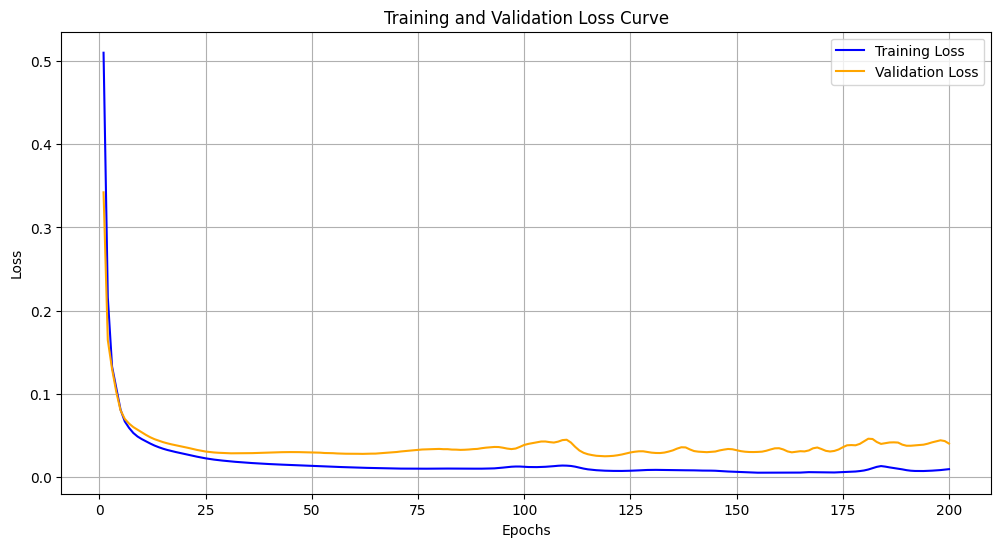

In [18]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load Dataset
file_path = '/kaggle/input/original-hiring-dataset/Hiring_dataset.csv'
df = pd.read_csv(file_path)

# Preprocessing Pipelines
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()

# Numeric Pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Column Transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Fit and Transform
X = preprocessor.fit_transform(df)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
print("Processed Data Shape:", X_tensor.shape)

# Train-Test Split
train_size = int(0.8 * len(X_tensor))
train_data, val_data = X_tensor[:train_size], X_tensor[train_size:]

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        embeddings = self.encoder(x)
        reconstructed = self.decoder(embeddings)
        return reconstructed, embeddings

# Initialize Model, Optimizer, and Loss Function
input_dim = X_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200
batch_size = 32

# Initialize lists for loss tracking
train_loss_history = []
val_loss_history = []

# Training Loop with Validation Loss
for epoch in range(epochs):
    model.train()
    
    # Training Loss
    epoch_train_loss = 0.0
    for i in range(0, len(train_data), batch_size):
        x_batch = train_data[i:i + batch_size]
        optimizer.zero_grad()
        reconstructed, _ = model(x_batch)
        loss = criterion(reconstructed, x_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / (len(train_data) / batch_size)
    train_loss_history.append(avg_train_loss)

    # Validation Loss
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i in range(0, len(val_data), batch_size):
            x_val_batch = val_data[i:i + batch_size]
            reconstructed, _ = model(x_val_batch)
            val_loss += criterion(reconstructed, x_val_batch).item()

        avg_val_loss = val_loss / (len(val_data) / batch_size)
        val_loss_history.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting the Loss Curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load Dataset
file_path = '/kaggle/input/original-hiring-dataset/Hiring_dataset.csv'
df = pd.read_csv(file_path)

# Preprocessing Pipelines
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object']).columns.tolist()

# Numeric Pipeline: Handling missing values and scaling numerical features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline: Handling missing values and encoding categorical features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Column Transformer: Apply preprocessing pipelines to respective feature types
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Fit and Transform: Apply transformations to the dataset
X = preprocessor.fit_transform(df)

# Convert the transformed data into PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
print("Processed Data Shape:", X_tensor.shape)

# Train-Test Split (80% for training, 20% for validation)
train_size = int(0.8 * len(X_tensor))
train_data, val_data = X_tensor[:train_size], X_tensor[train_size:]

# Autoencoder Model Definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        embeddings = self.encoder(x)
        reconstructed = self.decoder(embeddings)
        return reconstructed, embeddings

# Model Initialization, Optimizer, and Loss Function
input_dim = X_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Configuration
epochs = 100
batch_size = 32

# Loss Tracking
train_loss_history = []
val_loss_history = []

# Training Loop
for epoch in range(epochs):
    model.train()

    # Training Loss
    epoch_train_loss = 0.0
    for i in range(0, len(train_data), batch_size):
        x_batch = train_data[i:i + batch_size]
        optimizer.zero_grad()
        reconstructed, _ = model(x_batch)
        loss = criterion(reconstructed, x_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / (len(train_data) / batch_size)
    train_loss_history.append(avg_train_loss)

    # Validation Loss
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i in range(0, len(val_data), batch_size):
            x_val_batch = val_data[i:i + batch_size]
            reconstructed, _ = model(x_val_batch)
            val_loss += criterion(reconstructed, x_val_batch).item()

        avg_val_loss = val_loss / (len(val_data) / batch_size)
        val_loss_history.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

Processed Data Shape: torch.Size([1500, 17])
Epoch 10/100, Training Loss: 0.0461, Validation Loss: 0.0486
Epoch 20/100, Training Loss: 0.0262, Validation Loss: 0.0303
Epoch 30/100, Training Loss: 0.0186, Validation Loss: 0.0242
Epoch 40/100, Training Loss: 0.0147, Validation Loss: 0.0223
Epoch 50/100, Training Loss: 0.0124, Validation Loss: 0.0229
Epoch 60/100, Training Loss: 0.0108, Validation Loss: 0.0237
Epoch 70/100, Training Loss: 0.0093, Validation Loss: 0.0225
Epoch 80/100, Training Loss: 0.0083, Validation Loss: 0.0218
Epoch 90/100, Training Loss: 0.0099, Validation Loss: 0.0286
Epoch 100/100, Training Loss: 0.0141, Validation Loss: 0.0395
